# Physics Informed Neural Networks for Non-Linear Poisson Equation (Thomas Fermi Equation)


The Thomas-Fermi equation:
 
$$ \frac{d^2 y}{d x^2} = \frac{(y x_0)^{\frac{3}{2}}}{x^{\frac{1}{2}}} $$

Subject to:

$$ y(0) = 1 $$
$$ \frac{dy}{dx}(1) = y(1) $$


Where $x_0$ is a constant (the radius of the ion-sphere).

It is clear from the Thomas-Fermi equation and the boundary condition at $x = 0$, that the second derivative of $y$ diverges at $x = 0$. Therefore, we choose a loss function to minimise the contribution from points approaching $x = 0$:

$$ \mathcal{L}(y,y'',x,x_0) = \left(\frac{x^{\frac{1}{2}+m}}{x_0^{\frac{3}{2}}}\frac{d^2 y}{d x^2}  - x^m y^{\frac{3}{2}}\right)^2 $$

Where $m$ is some positive real number, e.g. $\frac{1}{2}$.

We consider transformations applied to our neural network which enforce the boundary conditions by construction. A sensible choice is of the form:

$$ w(x, x_0) = A(x) + B(x) \mathcal{N} + C(x) \mathcal{N}'$$
$$ y(x, x_0) = t(w) $$

Where $t(x)$ is some non-linear function to maintain positivity (e.g. $\exp(x)$). A, B and C are polynomial functions of $x$ only - these can be derived from the boundary conditions. $\mathcal{N}$ and $\mathcal{N}'$ are the PINN and its derivative w.r.t. $x$.

We know that the boundary value of $y(1)$ is a function of $x_0$, and therefore we make our PINN model a product of models:

$$ \mathcal{N}(x,x_0) = \mathcal{N}_{PINN} (x,x_0) \mathcal{N}_{BC}(x_0) $$



_Thanks to Guzman Sanchez Gonzalez for his work on PINNs for Thomas-Fermi which acted as basis for this project._

In [4]:
import jax
import jax.numpy as jnp
import jax.nn as jnn
import equinox as eqx
import matplotlib.pyplot as plt

## Problem statement:

Your task is to create a PINN capable of solving the Thomas-Fermi equation for a range of $x_0$ values.

- We must derive suitable functions for $A(x)$, $B(x)$ and $C(x)$ to respect the boundary conditions
- We must construct suitable NN architectures for the PINN and BC components
- 

In [ ]:
class TFPINNModel(eqx.Module):
    mlp_PINN: eqx.nn.MLP
    mlp_BC: eqx.nn.MLP
    m: float

    def __init__(self, width_size, depth, m, *, key, **kwargs):
        super().__init__(**kwargs)
        self.m = m
        key, subkey = jax.random.split(key)
        
        # Create optimal NN architecture
        base_model = eqx.nn.MLP(
            in_size=3,
            out_size='scalar',
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=subkey,
            use_final_bias=False
        )
        # Initialize the final linear layer to zero
        where = lambda m: m.layers[-1].weight
        self.mlp_PINN = eqx.tree_at(where, base_model, jnp.zeros_like(base_model.layers[-1].weight))

        key, subkey = jax.random.split(key)
        self.mlp_BC = eqx.nn.MLP(
            in_size='scalar',
            out_size='scalar',
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=subkey,
            use_final_bias=False
        )

    def w(self, x, x0):
        return jnp.sqrt(x) #jnp.sqrt(2 * x * x0)

    def boundary_condition_constraints(self,x):
        # To be completed as exercise
        A = 0.5 * x**2
        B = 1 - (1 - x)**2
        C = x * (1 - x)
        return A, B, C
    
    def PINN(self, x, x0):
        return self.mlp_PINN(jnp.array([self.w(x,x0), x, jnp.log10(x0)]))*self.mlp_BC(jnp.log10(x0))
    
    def dPINN(self, x, x0):
        return jax.grad(self.PINN)(x,x0)

    def y_NN(self, x, x0):
        A, B, C = self.boundary_condition_constraints(x)
        N = self.PINN(x, x0)
        Nprime = self.dPINN(x, x0)
        w = A + B * N + C * Nprime
        return jnp.exp(w)

    def y(self, x, x0):
        return self.y_NN(x, x0)

    def dydx(self, x, x0):
        return jax.grad(self.y)(x, x0)

    def d2ydx2(self, x, x0):
        return jax.grad(jax.grad(self.y))(x, x0)
    
    def __call__(self, x, x0):
        return eqx.filter_jit(eqx.filter_vmap(self.y))(x,x0)

    def residual_loss(self, x, x0):
        # To be completed as exercise
        loss = (x**(0.5+self.m) * self.d2ydx2(x,x0) / x0**1.5 - x**(self.m) * self.y(x,x0)**1.5)**2
        return loss

In [157]:
def create_training_data(Nsamples,x0_range,x_lower=1e-3, key = jax.random.PRNGKey(42)):
    key,subkey = jax.random.split(key)
    xs = x_lower + (1.0-x_lower)*jax.random.uniform(subkey,shape=(Nsamples,))
    key,subkey = jax.random.split(key)
    x0s = x0_range[0] + (x0_range[1]-x0_range[0])*jax.random.uniform(subkey,shape=(Nsamples,))
    return xs, x0s

In [158]:
import optax
from jax.flatten_util import ravel_pytree

def train_TFPINN(TFPINN, xs, x0s, batch_size, num_epochs, learning_rate, key = jax.random.PRNGKey(42), print_every=10):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(eqx.filter(TFPINN, eqx.is_inexact_array))

    def batch_loss_fn(TFPINN, xs, x0s):
        batched_loss = eqx.filter_vmap(TFPINN.residual_loss)
        loss = jnp.mean(batched_loss(xs, x0s))
        return loss
    
    @eqx.filter_jit
    def update(TFPINN, opt_state, batch_xs, batch_x0s):
        loss, grads = eqx.filter_value_and_grad(batch_loss_fn)(TFPINN, batch_xs, batch_x0s)
        flat_grad, _ = ravel_pytree(grads)
        grad_norm = jnp.linalg.norm(flat_grad)
        updates, opt_state = optimizer.update(grads, opt_state)
        TFPINN = eqx.apply_updates(TFPINN, updates)
        return TFPINN, opt_state, loss, grad_norm

    history = []
    for epoch in range(num_epochs):
        loss = []
        grad_norm = []
        for _ in range(len(xs)//batch_size):
            key, subkey = jax.random.split(key)
            batch_xs = jax.random.choice(subkey, xs, shape=(batch_size,), replace=True)
            key, subkey = jax.random.split(key)
            batch_x0s = jax.random.choice(subkey, x0s, shape=(batch_size,), replace=True)
            TFPINN, opt_state, _loss, _grad_norm = update(TFPINN, opt_state, batch_xs, batch_x0s)
            loss.append(_loss)
            grad_norm.append(_grad_norm)
        loss = jnp.mean(jnp.array(loss))
        grad_norm = jnp.mean(jnp.array(grad_norm))
        if epoch % print_every == 0:
            print(f"Epoch {epoch}, Loss: {loss}, Grad Norm: {grad_norm}")
        history.append(loss)
    
    return TFPINN, history


## Problems

- Train a PINN for $x_0 = 1$, what is the shape of the solution as function of $x$ and what is value at $x = 1$? What is the lowest loss value obtained?
- Train a PINN for $x_0$ in range $[0.5,5]$, how does the solution shape change with $x_0$? What is the lowest loss value obtained?

In [ ]:
Nsamples = int(1e6)
x0_range = [0.5,5.0]

xs, x0s = create_training_data(Nsamples,x0_range,x_lower=1e-5)

TFPINN = TFPINNModel(width_size=16, depth=3, m=0.5, key=jax.random.PRNGKey(1234))

In [173]:
batch_size = 2**12
num_epochs = 10
learning_rate = 1e-3

TFPINN, history = train_TFPINN(TFPINN, xs, x0s, batch_size, num_epochs, learning_rate, print_every=1)

Epoch 0, Loss: 0.0006869985954836011, Grad Norm: 0.15041279792785645
Epoch 1, Loss: 0.00036885100416839123, Grad Norm: 0.029450345784425735
Epoch 2, Loss: 0.00035264011239632964, Grad Norm: 0.04790028929710388
Epoch 3, Loss: 0.0003470923111308366, Grad Norm: 0.07124286144971848
Epoch 4, Loss: 0.00031775745446793735, Grad Norm: 0.07660862058401108
Epoch 5, Loss: 0.000288633193122223, Grad Norm: 0.08138682693243027
Epoch 6, Loss: 0.0002627953072078526, Grad Norm: 0.07327655702829361
Epoch 7, Loss: 0.00031942862551659346, Grad Norm: 0.1637931913137436
Epoch 8, Loss: 0.00022031556000001729, Grad Norm: 0.09218357503414154
Epoch 9, Loss: 0.00020717426377814263, Grad Norm: 0.10024787485599518


## Extension problems:

- What pathological solutions does the PINN fall into? Try a large value of $m$ to find these. Why does this occur?
- Can you train over a larger range of $x_0$ values? What changes to the model/training/data need to be made?
- (Difficult) The Thomas-Fermi-Dirac equation in an extension to Thomas-Fermi theory. The same boundary conditions apply but the equation is modified to the following:

$$ \frac{d^2 y}{d x^2} =  x \left(\epsilon x_0 + \sqrt{\frac{y x_0}{x}}\right)^3$$

Where $\epsilon$ is an additional constant (with value $\lesssim 0.2$). What modifications need to be made to the model/training/data? Show results for a range of $x_0$ and $\epsilon$ values.

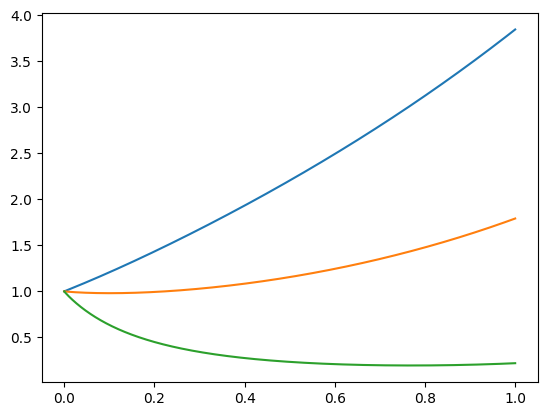

In [175]:
x0s_plot = [0.5,1.0,5.0]

for x0 in x0s_plot:
    x_plot = jnp.linspace(1e-5,1.0,1000)
    x0_plot = x0*jnp.ones_like(x_plot)

    untrained_TFPINN = TFPINNModel(width_size=16,depth=3,m=0.5,key=jax.random.PRNGKey(1234))

    plt.plot(x_plot,TFPINN(x_plot,x0_plot))
    # plt.plot([0.0,1.0],[0.0,TFPINN(x_plot[-1:],x0_plot[-1:])[0]],c='k')
    # plt.plot(x_plot,jax.vmap(TFPINN.y_NN)(x_plot,x0_plot))
    # plt.plot(x_plot,FeynmannMetropolisTeller_smallxsolution(x_plot,x0_plot,-0.6))
    # plt.ylim(0.0,1.6)
    # plt.plot(x_plot,jax.vmap(TFPINN.y_FMT)(x_plot,x0_plot))

    # plt.plot(x_plot,untrained_TFPINN(x_plot,x0_plot),ls='--')
    # plt.plot(x_plot,jax.vmap(untrained_TFPINN.y_NN)(x_plot,x0_plot),ls='--')
    # plt.plot(x_plot,jax.vmap(untrained_TFPINN.y_FMT)(x_plot,x0_plot),ls='--')
    # plt.twinx()
    # plt.semilogy(x_plot,jax.vmap(TFPINN.residual_loss)(x_plot,x0_plot),ls=':')
    # plt.plot(x_plot,jax.vmap(untrained_TFPINN.residual_loss)(x_plot,x0_plot),ls='--')
